In [5]:
import numpy as np
import pandas as pd

In [23]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained('allegro/herbert-base-cased')
bert_model = AutoModel.from_pretrained("allegro/herbert-base-cased") 

Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.sso.sso_relationship.bias', 'cls.sso.sso_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
from typing import Callable, List, Optional, Tuple
import pandas as pd
from sklearn.base import TransformerMixin, BaseEstimator
import torch
from IPython.display import clear_output

class BertTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, bert_tokenizer, bert_model, max_length):

        self.bert_tokenizer = bert_tokenizer
        self.bert_model = bert_model
        self.bert_model.eval()
        self.max_length = max_length
        self.embedding_func = lambda x: x[0][:, 0, :].squeeze()

    def _tokenize(self, text: str) -> Tuple[torch.tensor, torch.tensor]:
        tokenized_text = self.bert_tokenizer.encode_plus(text,
                                                         add_special_tokens=True,
                                                         max_length=self.max_length
                                                         )["input_ids"]

        attention_mask = [1] * len(tokenized_text)

        return (
            torch.tensor(tokenized_text).unsqueeze(0),
            torch.tensor(attention_mask).unsqueeze(0),
        )

    def _tokenize_and_predict(self, text: str, progress) -> torch.tensor:
        
        
        print(progress, flush=True)
        
        tokenized, attention_mask = self._tokenize(text)

        embeddings = self.bert_model(tokenized, attention_mask)
        
        clear_output(wait=True)
        return self.embedding_func(embeddings)

    def transform(self, text: List[str]):
        if isinstance(text, pd.Series):
            text = text.tolist()

        with torch.no_grad():
            return torch.stack([self._tokenize_and_predict(string, f'{text.index(string) + 1}/{len(text)}') for string in text])

    def fit(self, X, y=None):
        return self


In [22]:
X = 'nlp_4', 'nlp_5' # NLP ONLY
Y = 'GDT_score'
LABELS = []
DATASET = 'GDT_NLP_FULLSTOPS.xlsx'


In [19]:
df = pd.read_excel(io=DATASET)

nlp_labels = [f'nlp_{num}_label' for num in range(1, 7)]

print(len(df))

for nlp_label in nlp_labels:
    if nlp_label[:-6] in X:
        for num_label in LABELS:
            df = df[df[nlp_label] != num_label]

print(len(df))

df[f'{X[0]}_label'].value_counts()

522
522


Series([], Name: nlp_4_label, dtype: int64)

In [23]:
X_items = X
if len(X_items) > 1:

    print('multiple NLP items')

    X = 'nlp_n'
    
    df[X] = None

    for index, item in enumerate(X_items):
        if index == 0:
            df[X] = df[item]
        else:
            df[X] += df[item]

else:
    X = X[0]

print(X)

print(df[X][0])

multiple NLP items
nlp_n
Energia. Rozmach. Potencjał. Śmiałość. Nagłość. Bezbronność. Bezsiła. Bezradność. Bezsilność. Niemoc. 


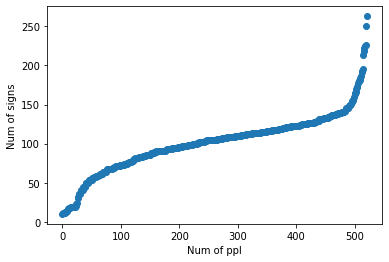

In [24]:
import matplotlib.pyplot as plt

len_arr = []
for items in df[X]:
    len_arr.append(len(items))
    
len_arr.sort()

plt.plot(len_arr, linestyle="", marker="o")
plt.xlabel('Num of ppl')
plt.ylabel('Num of signs')
plt.show()

In [29]:
bert_transformer = BertTransformer(tokenizer, bert_model, max_length=60)

X = bert_transformer.transform(df[X])
Y = df[Y]

522/522


In [30]:
from sklearn import svm

vector_regression = svm.SVR(kernel='linear', C=2.2, tol=1e-3)

In [31]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10)

results = []
for index in (kf.split(X)):
    slice_1 = min(index[1])
    slice_2 = max(index[1]) + 1
    
    x_test = X[slice_1:slice_2]
    
    x_train_1 = X[:slice_1]
    x_train_2 = X[slice_2:]

    x_train = torch.cat((x_train_1, x_train_2))

    y_train = list(Y[:slice_1]) + list(Y[slice_2:])
    y_test = Y[slice_1:slice_2]
    vector_regression.fit(x_train, y_train)
    result = vector_regression.predict(x_test)
    results = np.concatenate((results, result))


In [32]:
from scipy import stats
results = [item if item >= 4 else 4 for item in results]
results = [item if item <= 20 else 20 for item in results]

print(stats.pearsonr(results, Y))

PearsonRResult(statistic=0.26092713167758813, pvalue=1.4274771406121525e-09)


In [33]:
answers_tuples = [(y, res) for y, res in zip(Y, results)]
sorted_tuples = sorted(answers_tuples, key=lambda x: x[0])

test_y = [x[0] for x in sorted_tuples]
result = [x[1] for x in sorted_tuples]

rounded_result = [round(item) for item in result]

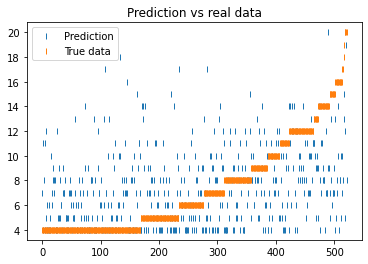

In [34]:
import matplotlib.pyplot as plt

plt.plot(range(len(result)), rounded_result, '|', linestyle = "", markerfacecolor='w', label="Prediction")
plt.plot(range(len(test_y)), test_y, '|', linestyle = "", label='True data')
plt.legend(loc='upper left')
plt.title('Prediction vs real data')
plt.show()

In [35]:
# testing new inputs

# from sklearn import svm

# test_vector_regression = svm.SVR(kernel='linear', C=2.2, tol=1e-3)
# testing_new_sentence = bert_transformer.transform(['Nie lubię', 'Nie lubie'])
# test_vector_regression.fit(X, Y)
# test_result = test_vector_regression.predict(testing_new_sentence)
# print(f'{test_result} points predicted')